Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
c:\Users\NilsWindows\Desktop\research2.0\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Processing algorithm: BC_20251112152746


c:\Users\NilsWindows\Desktop\research2.0\.venv\lib\site-packages\d3rlpy\torch_utility.py:431: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load(f, map_locatio


Processing algorithm: CQL_20251119124616
Selected 10 models out of 100 available models (including the latest)

Processing algorithm: CQL_20251120010016
Selected 10 models out of 100 available models (including the latest)

Processing algorithm: CQL_20251121045724
Selected 10 models out of 500 available models (including the latest)

Processing algorithm: CQL_20251121142727
Selected 10 models out of 500 available models (including the latest)

Processing algorithm: CQL_20251121213240
Selected 10 models out of 500 available models (including the latest)

Processing algorithm: IQL_20251112171109

Processing algorithm: PLAS_20251112165203

Processing algorithm: PLAS_20251122112937
Selected 10 models out of 500 available models (including the latest)

Processing algorithm: PLAS_20251123004355
Selected 10 models out of 1500 available models (including the latest)

Processing algorithm: PLAS_20251123125017
Selected 10 models out of 500 available models (including the latest)

Processing alg

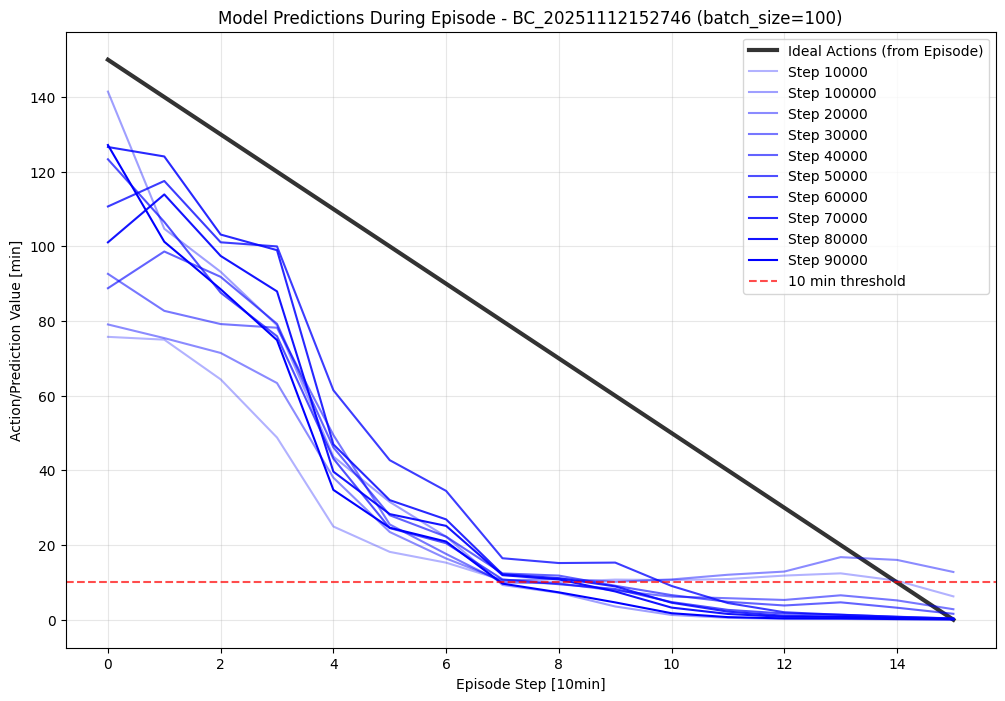

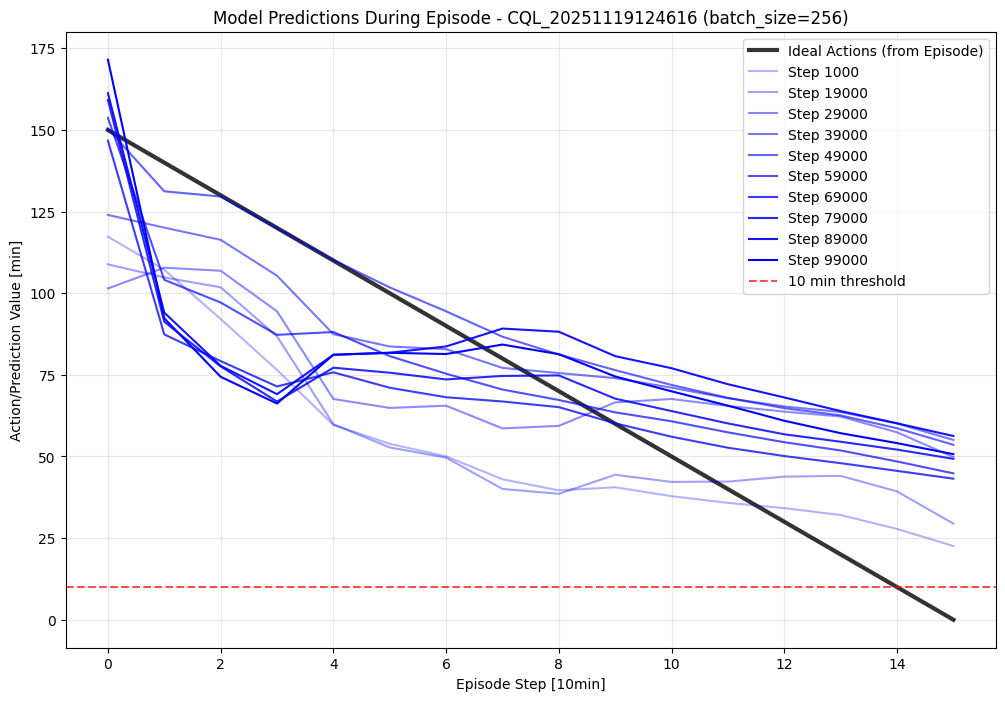

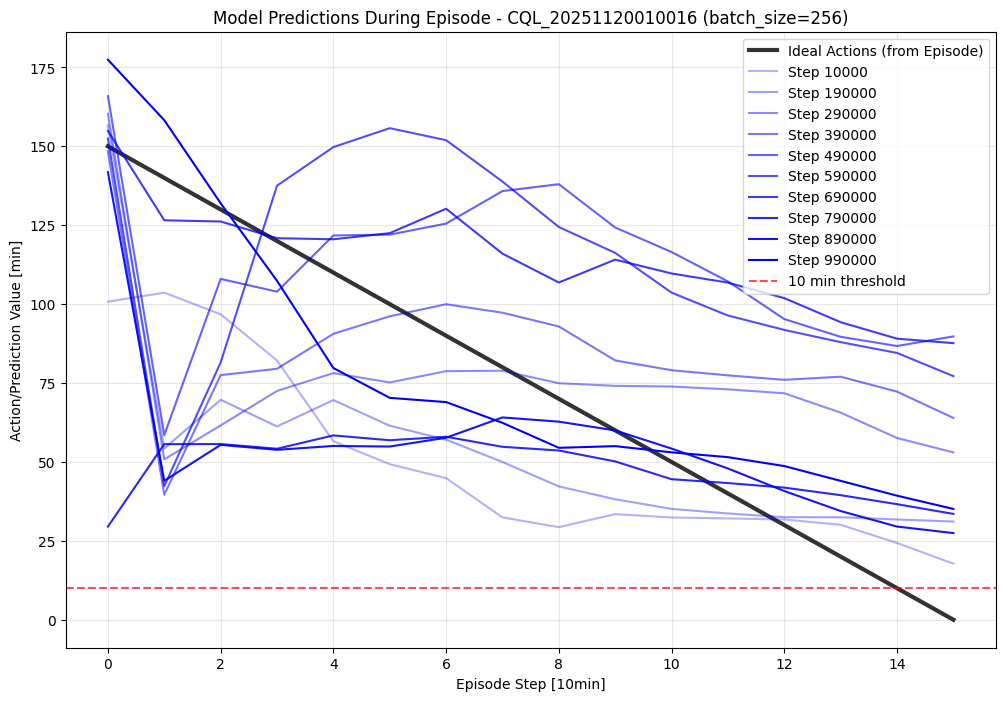

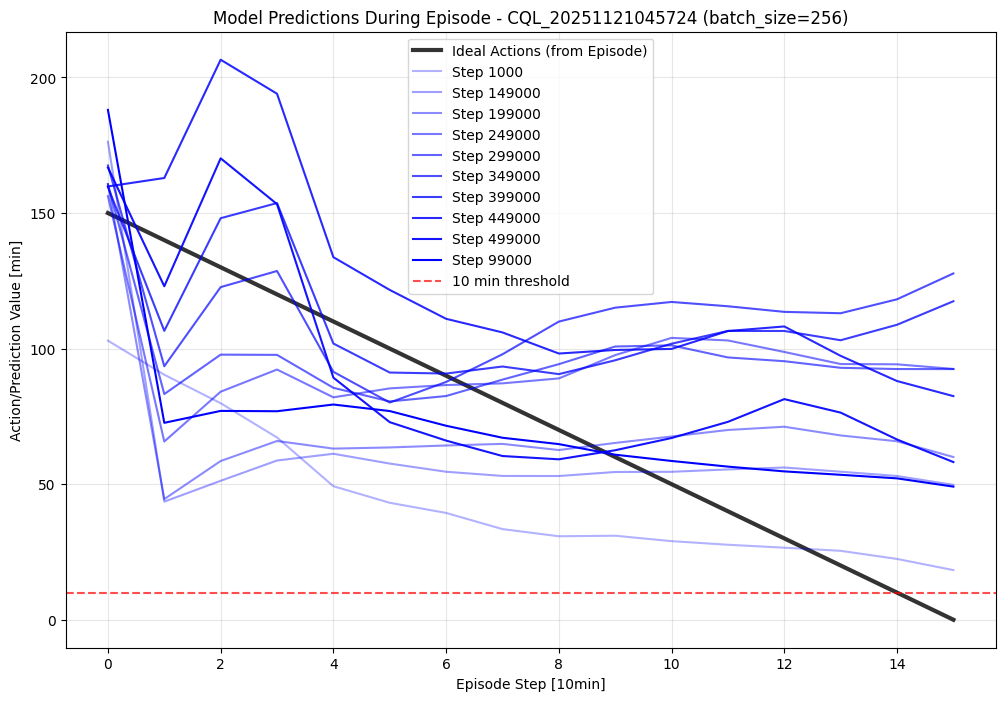

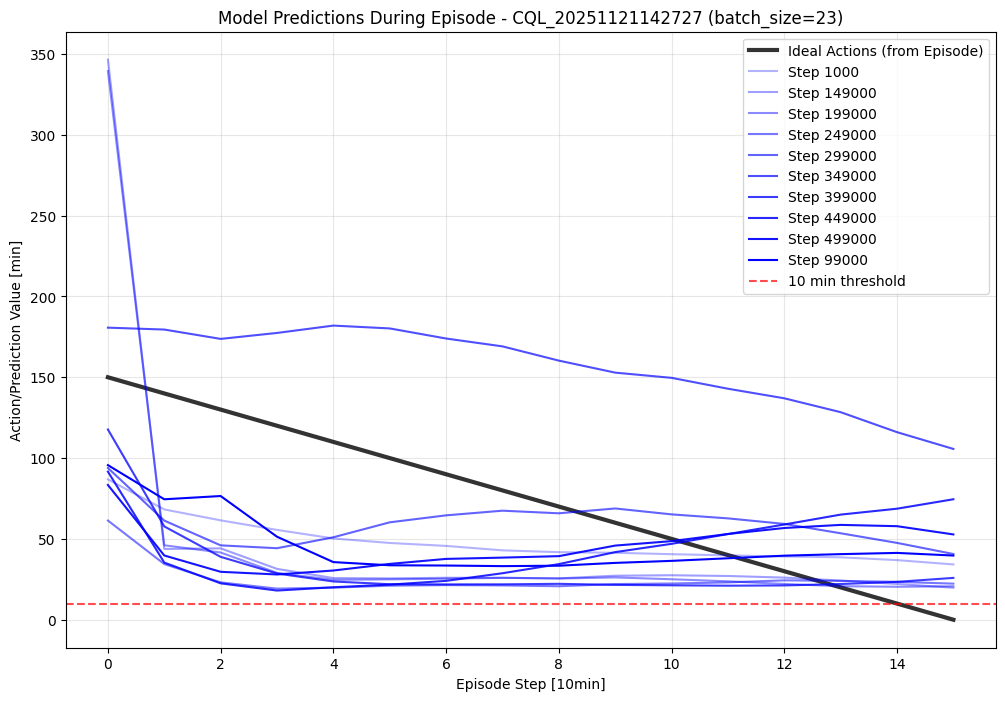

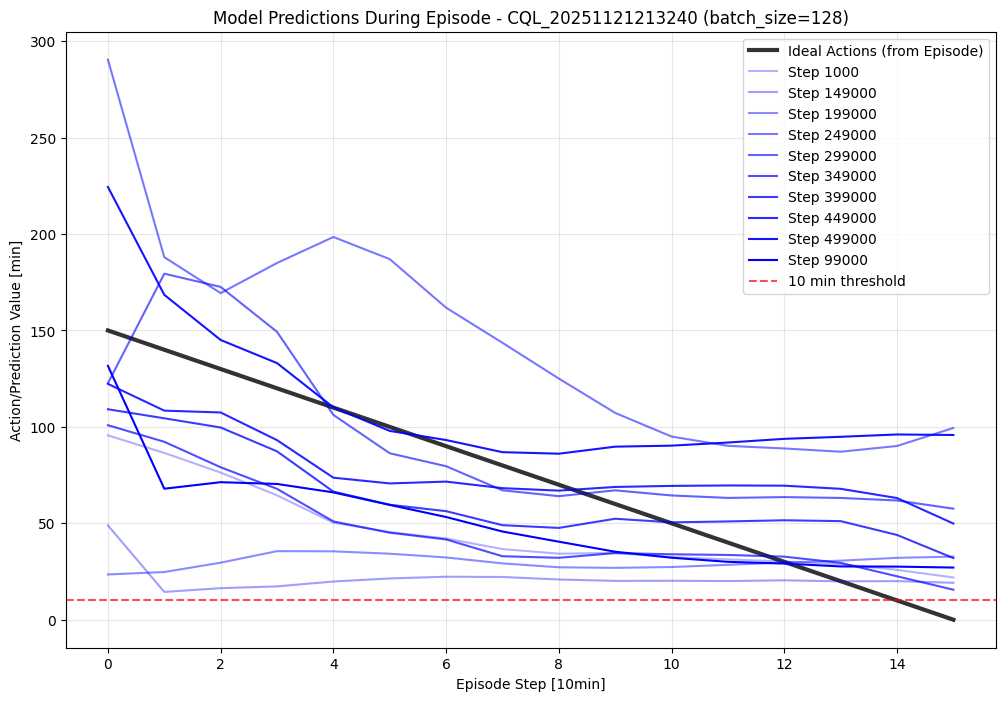

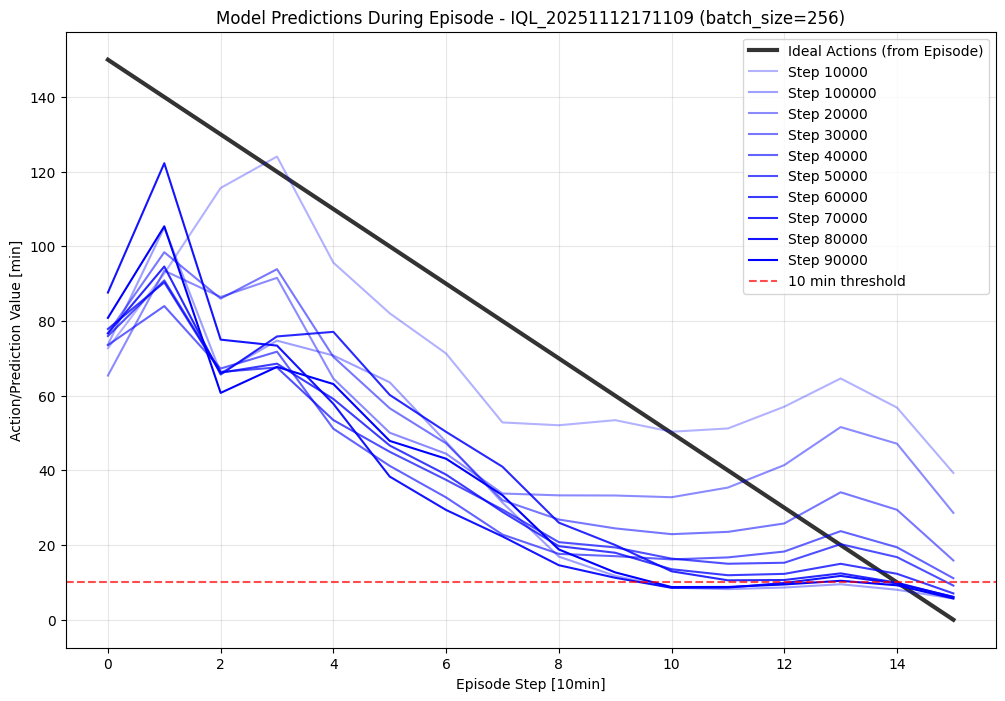

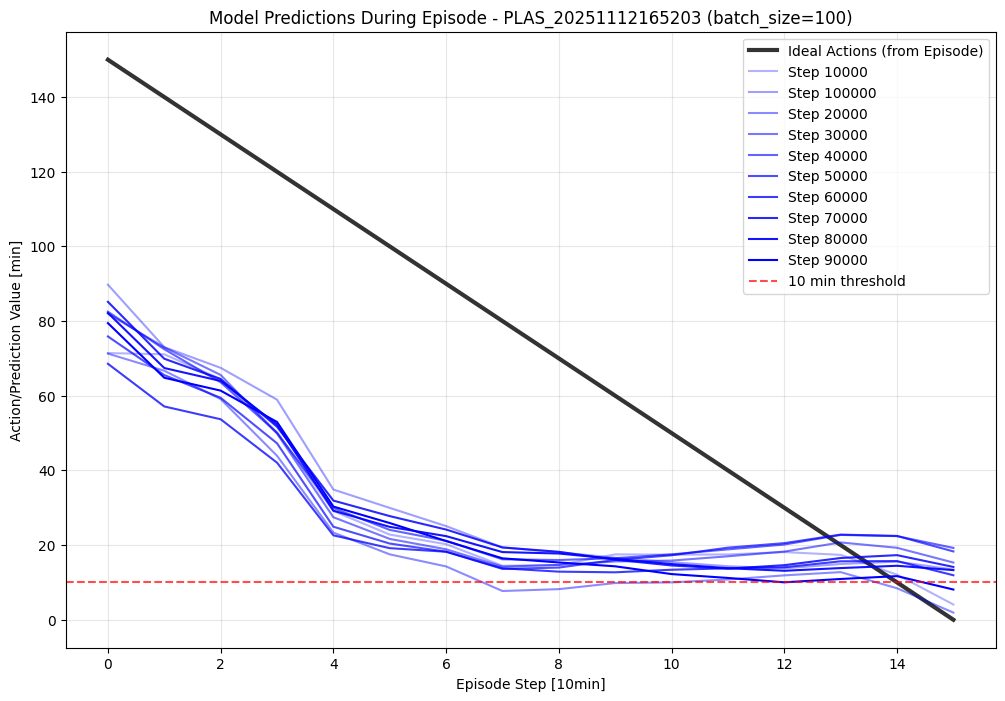

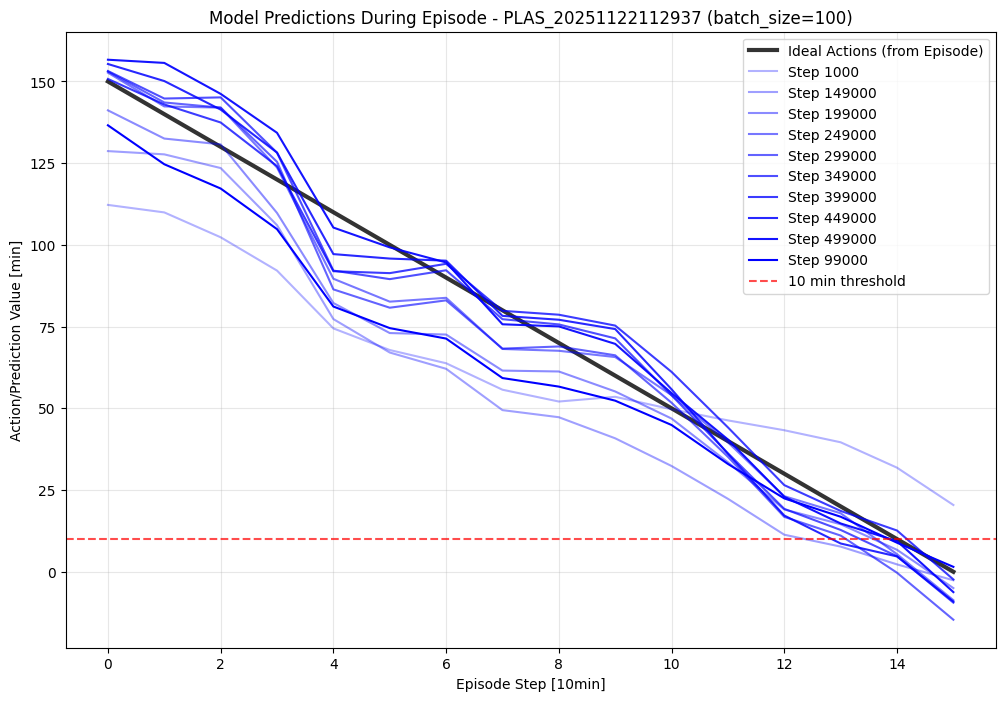

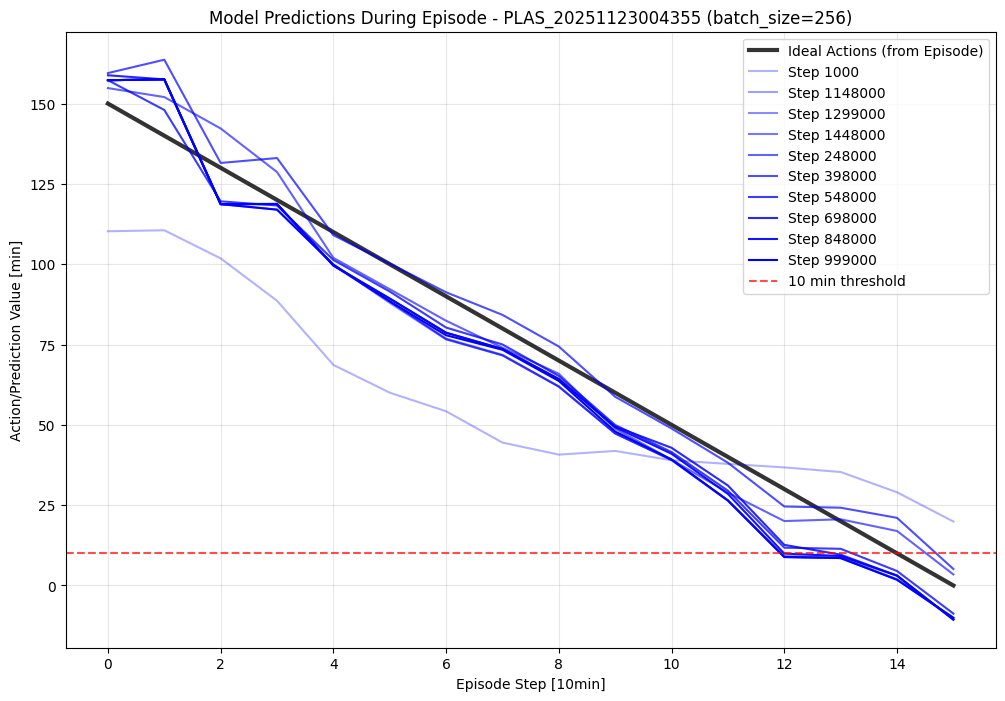

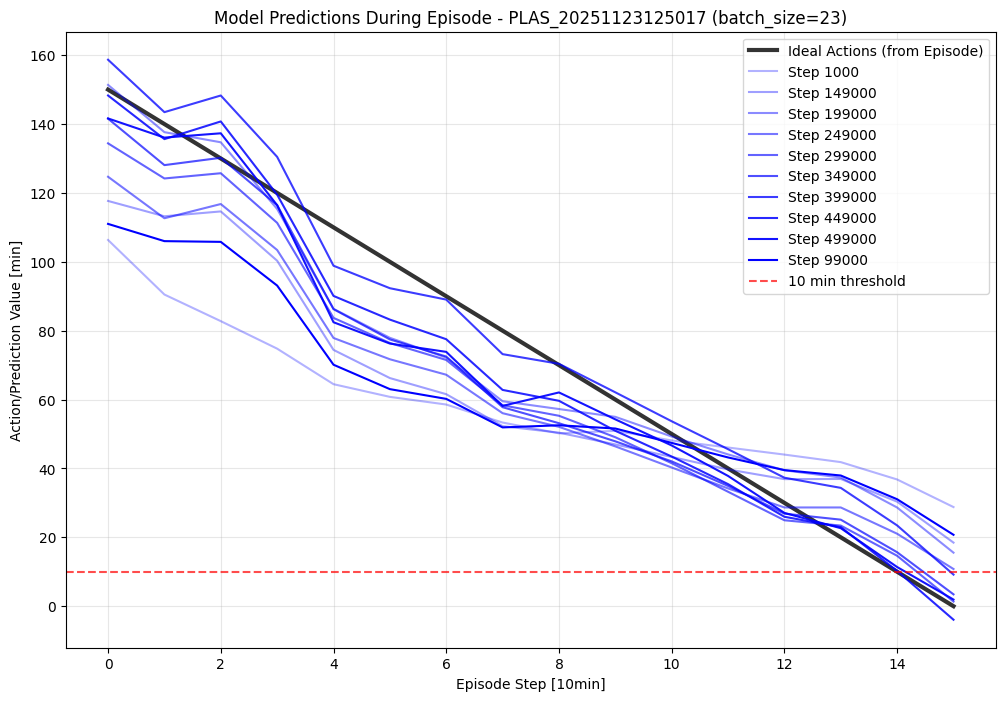

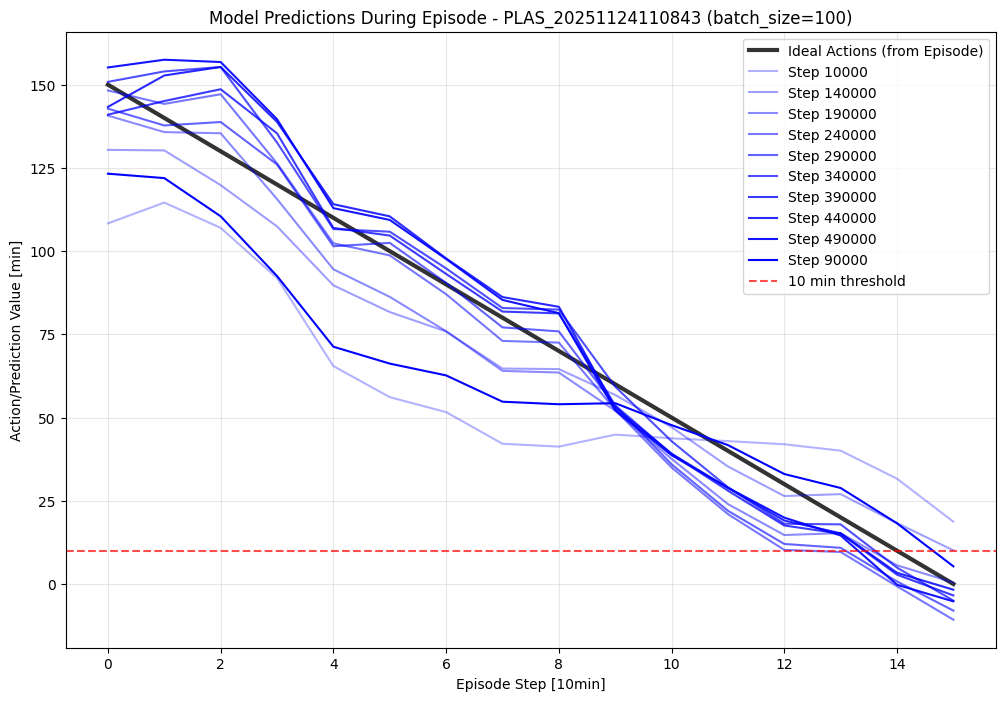

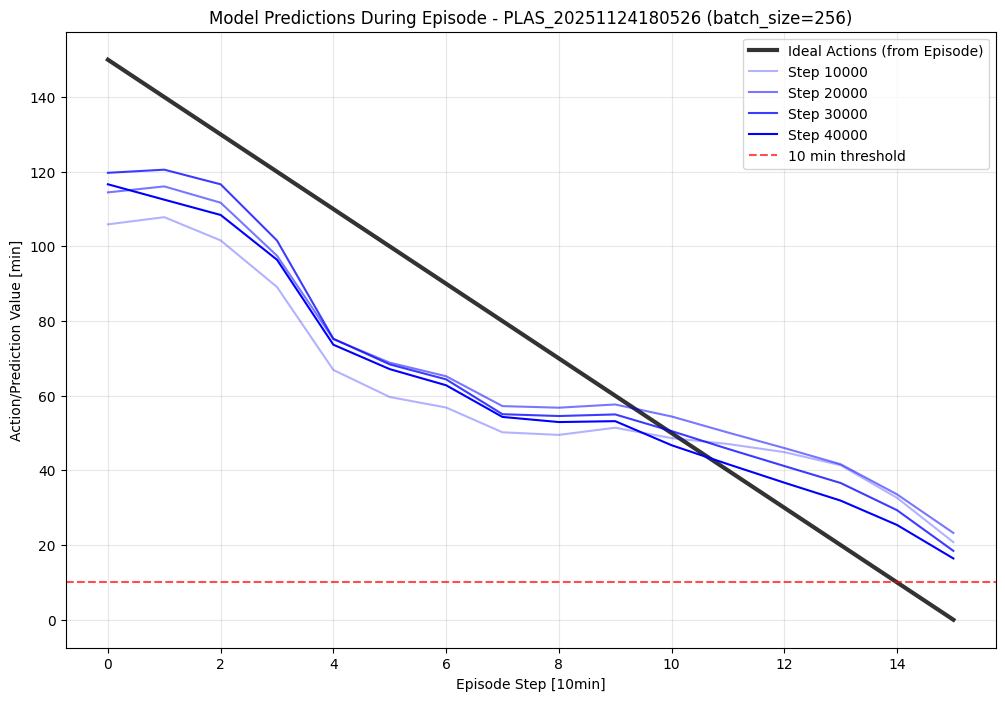

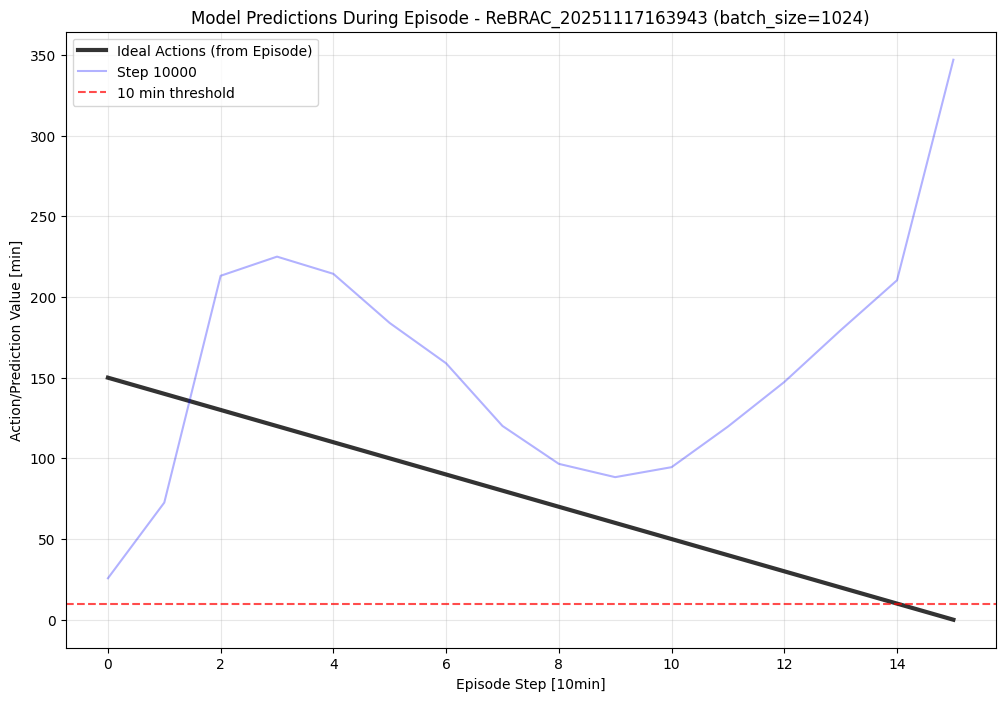

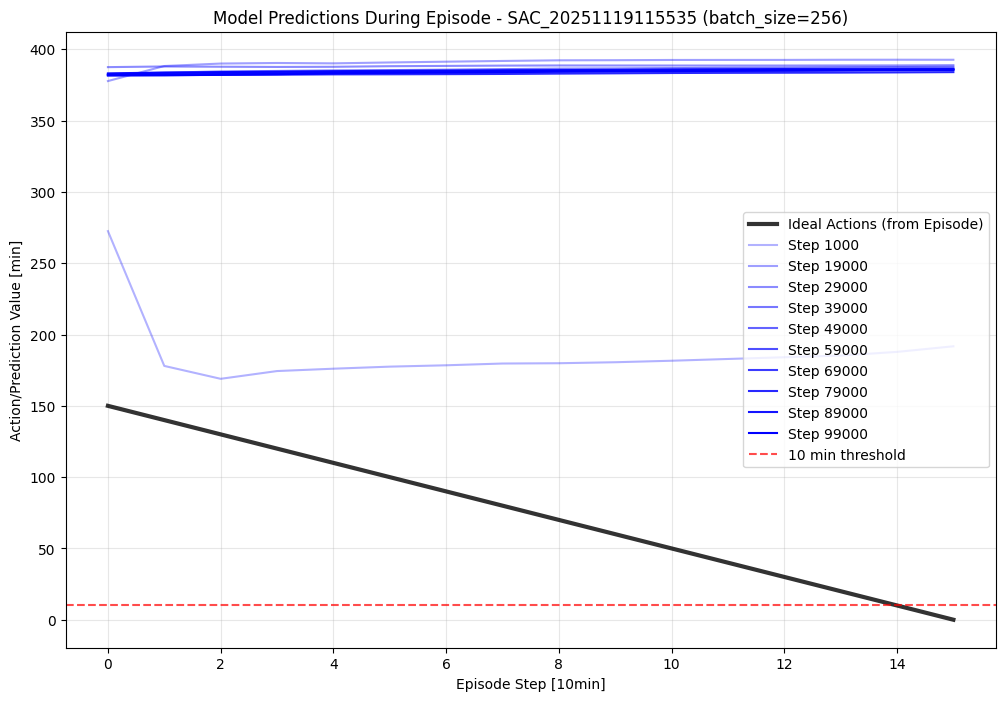

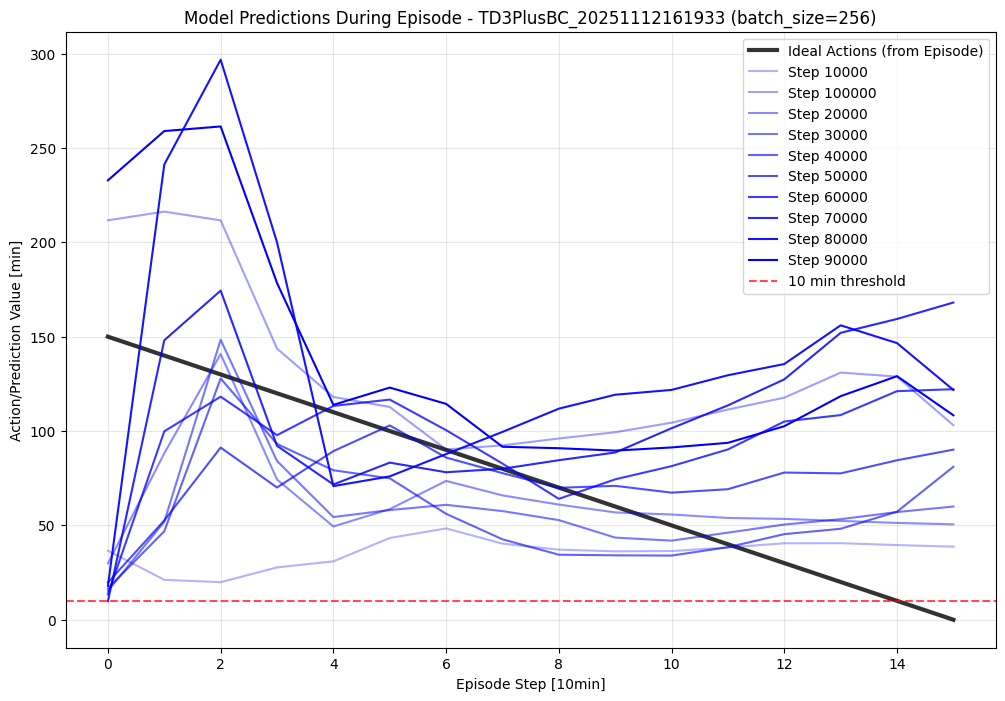

In [1]:
import os
import numpy as np
import d3rlpy
from pathlib import Path
import csv

import matplotlib.pyplot as plt
import json

# Set the base directory for d3rlpy logs
base_dir = "d3rlpy_logs"
testEpisode = "../data/episFormula/test"

#reads all the episodes in a particular folder and reutns them in a array consisting of arrays with tuples
def read_Episodes(baseFolder):
    episodes = []
    for filename in sorted(os.listdir(baseFolder)):
        filePath = os.path.join(baseFolder, filename)
        episode = []
        with open(filePath, "r", newline="") as file:
            reader = csv.reader(file)
            for row in reader:
                observation = [float(epi) for epi in row]
                episode.append(observation)
            episodes.append(episode)        
    return episodes

# Function to load models from a training directory (max 10, evenly distributed)
def load_models_from_training(training_dir):
    models = []
    model_files = sorted([f for f in os.listdir(training_dir) if f.endswith('.d3')])
    
    # Select maximum 10 models, evenly distributed, always including the last one
    if len(model_files) > 10:
        # Always include the last (newest) model
        selected_indices = []
        
        # Calculate step size for the first 9 models
        step = (len(model_files) - 1) / 9
        selected_indices = [int(i * step) for i in range(9)]
        
        # Always add the last model
        selected_indices.append(len(model_files) - 1)
        
        # Remove duplicates and sort
        selected_indices = sorted(list(set(selected_indices)))
        
        model_files = [model_files[i] for i in selected_indices]
        print(f"Selected {len(model_files)} models out of {len(sorted([f for f in os.listdir(training_dir) if f.endswith('.d3')]))} available models (including the latest)")
    
    for model_file in model_files:
        model_path = os.path.join(training_dir, model_file)
        try:
            # Load the model (adjust algorithm type as needed)
            model = d3rlpy.load_learnable(model_path)
            models.append((model_file, model))
        except Exception as e:
            print(f"Error loading {model_file}: {e}")
    
    return models

# Function to create episode visualization for all models
def create_episode_visualization(algorithm_name, models, epiPath, batch_size=None, n_steps_per_episode=None):
    plt.figure(figsize=(12, 8))
    
    # Create a simple test episode (replace with your actual environment)
    # This is a placeholder - you'll need to adapt this to your specific environment    
    epis = read_Episodes(epiPath)

    observations = []
    actions = []

    epi = epis[2]  # Using the first episode for visualization
    for observation in epi:
        observations.append(observation[:-2])
        actions.append(observation[-2:-1])

    observations=np.array(observations)
    actions=np.array(actions)
    
    # Plot the ideal actions first as thick reference line
    step_numbers = list(range(len(actions)))
    plt.plot(step_numbers, actions.flatten(), 
             label='Ideal Actions (from Episode)', 
             linewidth=3, 
             color='black', 
             alpha=0.8)
    
    for i, (model_name, model) in enumerate(models):
        try:
            # Get predictions from the model
            model_actions = []
            values = []
            # Method 1: Try batch prediction first (more efficient)
            try:
                # If observations already has correct shape (x, 7), try batch prediction
                batch_actions = model.predict(observations)
                model_actions = batch_actions.flatten().tolist() if batch_actions.ndim > 1 else batch_actions.tolist()
                
                # Try batch value prediction
                try:
                    batch_values = model.predict_value(observations)
                    values = batch_values.flatten().tolist() if batch_values.ndim > 1 else batch_values.tolist()
                except:
                    values = [0] * len(model_actions)
                    
            except Exception as batch_error:
                print(f"Batch prediction failed for {model_name}, using individual predictions: {batch_error}")
                
                # Method 2: Individual prediction with proper batch dimension
                for state in observations:
                    # Ensure state has batch dimension: (7,) -> (1, 7)
                    if state.ndim == 1:
                        state_batch = np.expand_dims(state, axis=0)
                    else:
                        state_batch = state
                    
                    action = model.predict(state_batch)[0]
                    model_actions.append(action)
                    
                    # If the model supports value estimation
                    try:
                        value = model.predict_value(state_batch)[0]
                        values.append(value)
                    except:
                        values.append(0)  # Default if value estimation not available
            
            # Plot the predictions with increasing intensity
            step_numbers = list(range(len(model_actions)))
            training_step = model_name.replace('.d3', '').split('_')[-1]
            
            # Calculate alpha based on position (from 0.3 to 1.0)
            alpha_value = 0.3 + (0.7 * (i / max(1, len(models) - 1)))
            
            plt.plot(step_numbers, model_actions, 
                    label=f'Step {training_step}', 
                    color='blue',  # Same color for all models
                    alpha=alpha_value,
                    linewidth=1.5)
            
        except Exception as e:
            print(f"Error predicting with {model_name}: {e}")
    
    # Add horizontal line at 10 minutes
    plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='10 min threshold')
    
    # Titel mit batch_size und n_steps_per_episode ergänzen
    title = f'Model Predictions During Episode - {algorithm_name}'
    if batch_size is not None and n_steps_per_episode is not None:
        title += f' (batch_size={batch_size}, n_steps_per_episode={n_steps_per_episode})'
    elif batch_size is not None:
        title += f' (batch_size={batch_size})'
    elif n_steps_per_episode is not None:
        title += f' (n_steps_per_episode={n_steps_per_episode})'
    plt.title(title)
    plt.xlabel('Episode Step [10min]')
    plt.ylabel('Action/Prediction Value [min]')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
# Main execution
if os.path.exists(base_dir):
    # Get all algorithm directories
    algorithm_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    for algorithm_name in algorithm_dirs:
        algorithm_path = os.path.join(base_dir, algorithm_name)
        print(f"\nProcessing algorithm: {algorithm_name}")

        # Versuche params.json zu laden
        params_path = os.path.join(algorithm_path, 'params.json')
        batch_size = None
        n_steps_per_episode = None
        if os.path.exists(params_path):
            try:
                with open(params_path, 'r') as f:
                    params = json.load(f)
                    batch_size = params.get('config', {}).get('params', {}).get('batch_size', None)
                    n_steps_per_episode = params.get('config', {}).get('params', {}).get('n_steps_per_episode', None)
            except Exception as e:
                print(f"Fehler beim Laden von params.json: {e}")

        # Load all models from this algorithm's training
        models = load_models_from_training(algorithm_path)
        
        if models:
            # Create visualization for this algorithm
            create_episode_visualization(algorithm_name, models, testEpisode, batch_size, n_steps_per_episode)
        else:
            print(f"No models found in {algorithm_path}")
else:
    print(f"Directory {base_dir} not found!")